# Überwachtes Lernen

### Zielparameter: Breitengrad (Latitude)

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics, cross_validation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import math

### 1. Stellen Sie sicher, dass sowohl Trainings- als auch Validierungsdaten zur Anwendung von ML- Verfahren geeignet sind. Weisen deren Features und Zielwerte die gleiche Verteilung auf?

In [20]:
training_data = '../data/training_data_preprocessed.csv'
training_data = pd.read_csv(training_data, index_col=0)
print(training_data.columns)
print(training_data.shape)

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['timeAtServer', 'aircraft', 'latitude', 'longitude', 'baroAltitude',
       'geoAltitude', 'serial_1', 'timestamp_1', 'signalstrength_1',
       'serial_2', 'timestamp_2', 'signalstrength_2', 'latitude_sensor_1',
       'longitude_sensor_1', 'height_1', 'type_1', 'latitude_sensor_2',
       'longitude_sensor_2', 'height_2', 'type_2'],
      dtype='object')
(1839588, 20)


Zuerst wählen wir die Spalten aus, die später als Feature dienen sollen. Dafür behalte ich den ursprünglichen Datensatz bei und lösche die Spalten 
* id
* timeAtServer
* latitude
* longitude
* geoAltitude
* serial_1
* serial_2  

da sie meiner Meinung nach irrelevant für die Bestimmung der Position sind. Bei `latitude`, `longitude` und `geoAltitude` handelt es sich um die Zielvariablen.

Ich skaliere zunächst keine Werte. Falls die Performance des Verfahrens schlecht ist, könnte an dieser Stelle noch einmal angesetzt werden.

In [21]:
feature_columns = ['aircraft','baroAltitude', 
           'timestamp_1', 'signalstrength_1', 'latitude_sensor_1', 'longitude_sensor_1', 'height_1', 'type_1', 
           'timestamp_2', 'signalstrength_2','latitude_sensor_2', 'longitude_sensor_2', 'height_2', 'type_2'] 
target_columns = ['latitude']

Der Datensatz wird nun in train und Validation geteilt. Ich entscheide mich dabei für einen 80/20-Split. Da 20% von 1.839.588 immer noch eine große Anzahl an samples darstellt, ergibt dieser Split Sinn.

In [22]:
X_train, X_validate, y_train, y_validate = train_test_split(training_data[feature_columns], 
                                                            training_data[target_columns],
                                                           test_size=0.8, random_state=42) 

Nachfolgend werden die Features und Zielwerte des Trainings- und Validierungsdatensatzes vergleichen, um zu überprüfen, ob sie die gleiche Verteilung haben.

Links ist jeweils die Verteilung in den Trainingsdaten und rechts in den Validierungsdaten dargestellt

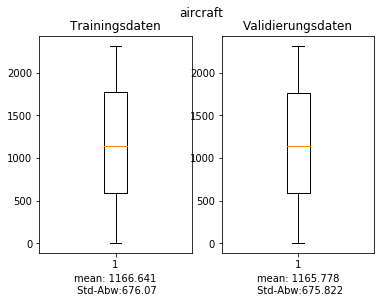

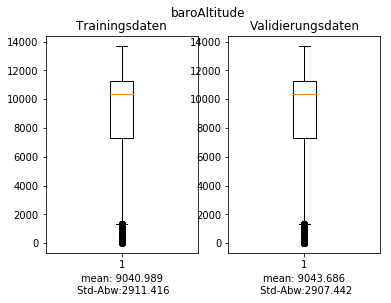

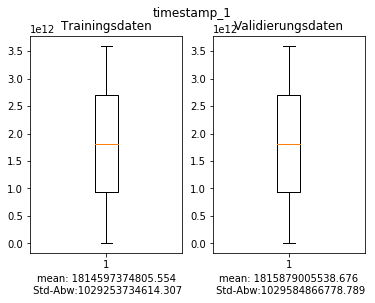

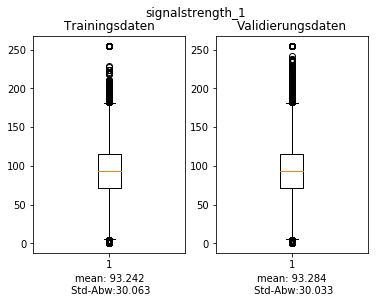

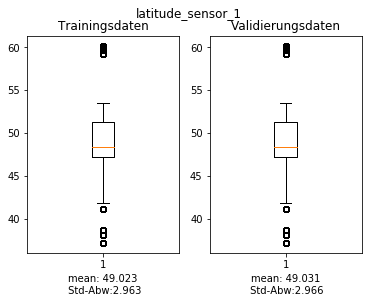

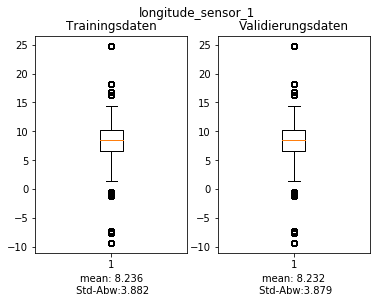

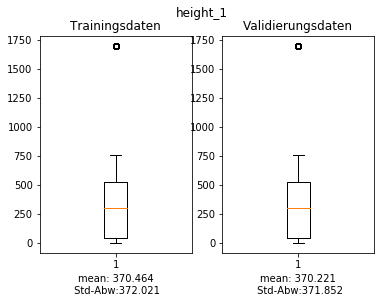

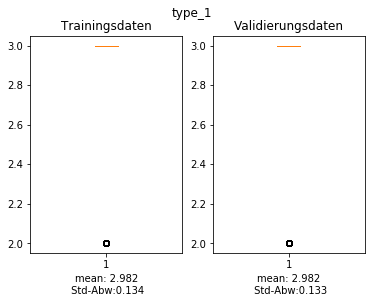

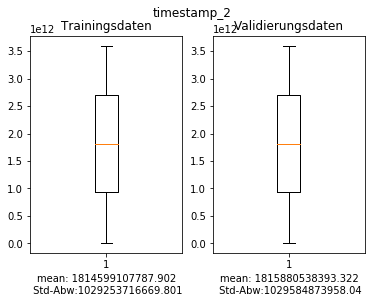

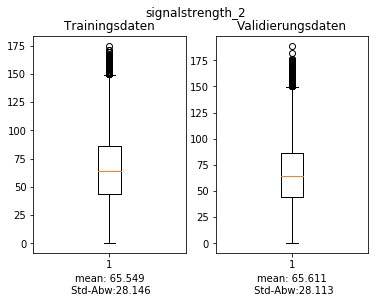

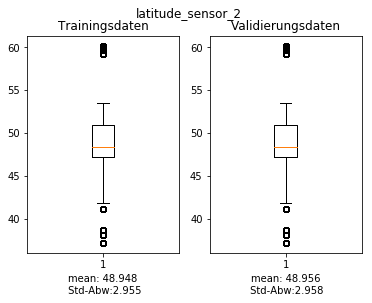

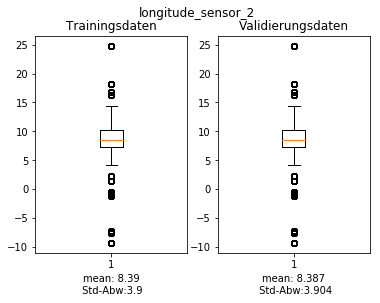

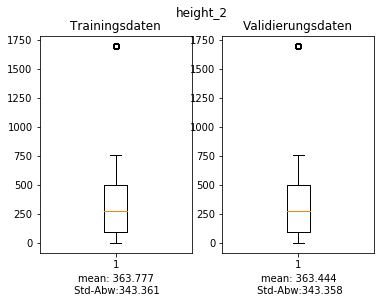

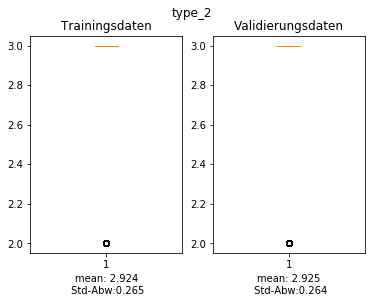

In [44]:
%matplotlib inline  
for column in X_train:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(column)
    ax1.set_title('Trainingsdaten')
    ax1.set_xlabel('mean: ' + str(round(X_train[column].mean(),3)) + '\n Std-Abw:' + str(round(X_train[column].std(),3)))
    ax2.set_title('Validierungsdaten')
    ax2.set_xlabel('mean: ' + str(round(X_validate[column].mean(),3))+ '\n Std-Abw:' + str(round(X_validate[column].std(),3)))
    ax1.boxplot(X_train[column])
    ax2.boxplot(X_validate[column])


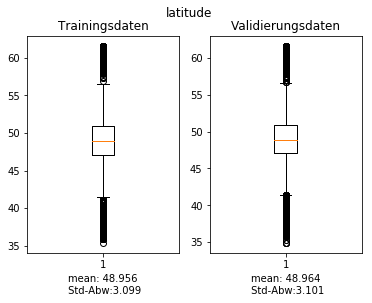

In [45]:
%matplotlib inline  
for column in y_train:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(column)
    ax1.set_title('Trainingsdaten')
    ax1.set_xlabel('mean: ' + str(round(y_train[column].mean(),3)) + '\n Std-Abw:' + str(round(y_train[column].std(),3)))
    ax2.set_title('Validierungsdaten')
    ax2.set_xlabel('mean: ' + str(round(y_validate[column].mean(),3))+ '\n Std-Abw:' + str(round(y_validate[column].std(),3)))
    ax1.boxplot(y_train[column])
    ax2.boxplot(y_validate[column])

Wie man anhand der Boxplots und der Mittelwerte erkennen kann, sind die Daten im Trainings- und Validierungsdatensatz gleich verteilt.

### 2. Legen Sie mindestens eine Metrik fest, anhand derer Sie den Erfolg Ihres überwachten Lernverfahrens messen werden. Begründen Sie Ihre Wahl.

* MSE (Mean Squared Error)
* MAE (Mean absolute error)
* MAPE (Mean Absolute Percentage Error)

**Begründung:** MSE und MAE sind sehr übrlich bei Regressionsaufgaben und werden auch bei ähnlichen Aufgaben und Forschungsergebnissen (*Zhengyi Wang, Man Liang, Daniel Delahaye, 2020: Automated Data-Driven Prediction on Aircraft Estimated Time of Arrival*) verwendet. Außerdem handelt es sich dabei um ein recht informatives Maß, da man insb. mit dem MAE die absolute Abweichung in Längeneinheiten der prediction von der Beobachtung betrachten kann. MAPE dient als Vergleichsmaß mit den anderen Teilnehmerinnen des Seminars, da dieses Maß von der Mehrzahl der Gruppen mit einbezogen wurde. 


### 3. Nutzen Sie eine erkenntnisfreie Baseline-Methode( z.B. Mittelwert aller Zielwerte),um naive Vorhersagen für die Validierungsdaten zu generieren. Speichern Sie die Vorhersagen in einer Datei.

Ich werden den Mittelwert der Trainingsdaten als naiven Schätzer für den Breitengrad der Validierungsdaten verwenden

In [27]:
naive_lat_prediction = y_train['latitude'].mean()

In [28]:
naive_lat_prediction_df = pd.DataFrame(X_validate.index.tolist(), columns=['id'])
naive_lat_prediction_df.set_index('id',inplace=True)
naive_lat_prediction_df['prediction'] = naive_lat_prediction
naive_lat_prediction_df.to_csv('../results/naive_prediction_lat.csv')

### 4. Nutzen Sie eine möglichst einfache Baseline-Methode (z.B. Entscheidungsbaum), um plausible Vorhersagen für die Validierungsdaten zu erzielen. Speichern Sie die Vorhersagen in einer Datei.

Als Baseline-Methode werde ich eine lineare Regression verwenden. Scikit learn bitete hier keine Parameter, die getunt werden könnten.

In [29]:
linear_lat=LinearRegression().fit(X_train, y_train)


In [30]:
linear_lat_predictions = X_validate.copy()
linear_lat_predictions['predictions'] = linear_lat.predict(X_validate)
linear_lat_predictions=linear_lat_predictions.drop(feature_columns, axis=1)
linear_lat_predictions.to_csv('../results/linear_prediction_lat.csv')

Eine Koeffizientenanalyse zeigt, dass die Breitengrade der Sensoren, sowie der Typ des Sensors den größten Einfluss auf die Zielvariable haben. Alle anderen Feature haben einen sehr kleinen bis hin zu verlachlässigbaren Einfluss. 

In [46]:
coefs = [item.round(8) for item in linear_lat.coef_[0]]
coefficients = dict(zip(X_train.columns, coefs))
sorted_coefficients = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_coefficients

[('latitude_sensor_1', 0.5872963),
 ('latitude_sensor_2', 0.44294692),
 ('type_1', -0.35480764),
 ('type_2', -0.32993184),
 ('longitude_sensor_2', -0.01391571),
 ('longitude_sensor_1', 0.01057731),
 ('signalstrength_2', 0.00066184),
 ('signalstrength_1', 0.00027208),
 ('height_1', -4.862e-05),
 ('aircraft', -4.284e-05),
 ('height_2', -1.443e-05),
 ('baroAltitude', 4.45e-06),
 ('timestamp_1', 0.0),
 ('timestamp_2', -0.0)]

### 5. Nutzen Sie ein etabliertes neuroinspiertes oder statistisch motiviertes überwachtes Lernverfahren, um eine Vorhersage für die Validierungsdaten zu erreichen. Begründen Sie Ihre Wahl und speichern die Vorhersagen in einer Datei.

Ich entscheide mich für einen Gradient Boosting Regressor als erstes statistisch motiviertes überwachtes Lernverfahren. Zur Implementierung nutze ich sklearn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

Bevor ich den GBR mit dem kompletten Datensatz trainiere, führe ich Parameter-Tuning mit einem kleineren Subsample aus. Folgende Paramter möchte ich tunen, um die Performance zu verbessern (zitiert aus scikitlearns [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html):

* `max_dept`: int, default=3. maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.
* `n_estimator`: int, default=100. The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
  
Ich habe diese beiden Parameter gewählt, da aus der Dokumentation hervorgeht, dass Tuning hier zu einer besseren Performance führen kann.

#### Hyperparameter-Tuning : n_estimators

In [87]:
n_estimators = [10, 100, 1000]
for estimator in n_estimators:
    gbr_lat = GradientBoostingRegressor(random_state=0, n_estimators = estimator)
    gbr_lat.fit(X_train[:10000], y_train[:10000])
    gbr_lat_predictions = X_validate.copy()
    gbr_lat_predictions['predictions'] = gbr_lat.predict(X_validate)
    gbr_lat_predictions=gbr_lat_predictions.drop(feature_columns, axis=1)
    gbr_lat_predictions.to_csv('../results/gbr_prediction_lat_' + str(estimator) + '_estimators' + '.csv')

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
n_estimators = [10, 100, 1000]
index=['n_estimators = ' + str(n) for n in n_estimators]
estimator_evaluation = pd.DataFrame(index=index)

mae_evaluation = []
for n in n_estimators:
    file = '../results/gbr_prediction_lat_' + str(n) + '_estimators' + '.csv'
    prediction = pd.read_csv(file) 
    mae_evaluation.append(round(mean_absolute_error(y_validate, prediction['predictions'].tolist()),3))
    
mse_evaluation = []
for n in n_estimators:
    file = '../results/gbr_prediction_lat_' + str(n) + '_estimators' + '.csv'
    prediction = pd.read_csv(file) 
    mse_evaluation.append(round(mean_squared_error(y_validate, prediction['predictions'].tolist()),3))
    
estimator_evaluation['MAE'] = mae_evaluation
estimator_evaluation['MSE'] = mse_evaluation

estimator_evaluation

MAE    MSE
n_estimators = 10    0.966  1.686
n_estimators = 100   0.418  0.315
n_estimators = 1000  0.371  0.265

#### Hyperparameter-Tuning: max_depth

In [14]:
max_depth = [3,5,10,15]
for m in max_depth:
    gbr_lat = GradientBoostingRegressor(random_state=0, max_depth = m)
    gbr_lat.fit(X_train[:10000], y_train[:10000])
    gbr_lat_predictions = X_validate.copy()
    gbr_lat_predictions['predictions'] = gbr_lat.predict(X_validate)
    gbr_lat_predictions=gbr_lat_predictions.drop(feature_columns, axis=1)
    gbr_lat_predictions.to_csv('../results/gbr_prediction_lat_max_depth_' + str(m) + '.csv')

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
max_depth = [3,5,10,15]
index=['max_depth = ' + str(m) for m in max_depth]
max_depth_evaluation = pd.DataFrame(index=index)

mae_evaluation = []
for m in max_depth:
    file = '../results/gbr_prediction_lat_max_depth_' + str(m) + '.csv'
    prediction = pd.read_csv(file) 
    mae_evaluation.append(round(mean_absolute_error(y_validate, prediction['predictions'].tolist()),3))
    
mse_evaluation = []
for m in max_depth:
    file = '../results/gbr_prediction_lat_max_depth_' + str(m) + '.csv'
    prediction = pd.read_csv(file) 
    mse_evaluation.append(round(mean_squared_error(y_validate, prediction['predictions'].tolist()),3))
    
max_depth_evaluation['MAE'] = mae_evaluation
max_depth_evaluation['MSE'] = mse_evaluation

max_depth_evaluation

MAE    MSE
max_depth = 3   0.418  0.315
max_depth = 5   0.380  0.276
max_depth = 10  0.341  0.253
max_depth = 15  0.369  0.307

Wie man sieht, werden die besten ERgebnisse für `n_estimators`=1000 und `max_depth`=3 erzielt. Es wird also ein GBR mit diesen Paramtern trainiert und außerdem einer mit den default-Einstellungen zum Vergleich.

In [34]:
gbr_lat_tuned = GradientBoostingRegressor(random_state=0, n_estimators = 1000, max_depth=3)
gbr_lat_tuned.fit(X_train, y_train)
gbr_lat_tuned_predictions = X_validate.copy()
gbr_lat_tuned_predictions['predictions'] = gbr_lat.predict(X_validate)
gbr_lat_tuned_predictions=gbr_lat_predictions.drop(feature_columns, axis=1)
gbr_lat_tuned_predictions.to_csv('../results/gbr_prediction_lat_tuned.csv')

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
gbr_lat = GradientBoostingRegressor(random_state=0, n_estimators = 1000, max_depth=3)
gbr_lat.fit(X_train, y_train)
gbr_lat_predictions = X_validate.copy()
gbr_lat_predictions['predictions'] = gbr_lat.predict(X_validate)
gbr_lat_predictions=gbr_lat_predictions.drop(feature_columns, axis=1)
gbr_lat_predictions.to_csv('../results/gbr_prediction_lat.csv')

### 6. Vergleichen Sie mithilfe der von Ihnen festgelegten Metrik(en) die Vorhersagen Ihrer naiven Baseline-Methode, Ihrer einfachen Baseline-Methode und Ihres neuroinspirierten bzw. statistisch motivierten Lernverfahrens mit den tatsächlichen Zielwerten.


In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
gbr_lat_predictions = pd.read_csv('../results/gbr_prediction_lat.csv', index_col=0)
gbr_lat_predictions_tuned = pd.read_csv('../results/gbr_prediction_lat_tuned.csv', index_col=0)
predictions = [naive_lat_prediction_df, linear_lat_predictions, gbr_lat_predictions, gbr_lat_predictions_tuned]
index=['Dummy (Mittelwert)', 'Lineare Regression', 'GBR', 'GBR (tuned)']
evaluation = pd.DataFrame(index=index)

mae_evaluation = []
for prediction in predictions:
    mae_evaluation.append(round(mean_absolute_error(y_validate, prediction),3))
    
mape_evaluation = []
for prediction in predictions:
    mape_evaluation.append(round(mean_absolute_percentage_error(y_validate, prediction),3))
    
mse_evaluation = []
for prediction in predictions:
    mse_evaluation.append(round(mean_squared_error(y_validate, prediction),3))
    
evaluation['MAPE'] = mape_evaluation
evaluation['MAE'] = mae_evaluation
evaluation['MSE'] = mse_evaluation
evaluation['RMSE'] = [round(math.sqrt(n),3) for n in mse_evaluation]
evaluation['RMSE in km'] = [round(math.sqrt(n) * 111 ,3) for n in mse_evaluation]


evaluation

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


MAPE    MAE    MSE   RMSE  RMSE in km
Dummy (Mittelwert)  4.745  2.314  9.615  3.101     344.190
Lineare Regression  1.170  0.570  0.564  0.751      83.361
GBR                 0.849  0.413  0.306  0.553      61.402
GBR (tuned)         0.211  0.103  0.042  0.205      22.748

Als Fehlermetrik zur Evaluierung der Modelle dienen MSE (Mean Squared Error), MAE (Mean absolute error) und MAPE (Mean Absolute Percentage Error)
MSE und MAE sind sehr übrlich bei Regressionsaufgaben und werden auch bei ähnlichen Aufgaben und Forschungsergebnissen \cite{wangAutomatedDatadrivenPrediction2020} verwendet. 
Außerdem handelt es sich dabei um ein recht informatives Maß, da man insbesondere mit dem MAE die absolute Abweichung in Längeneinheiten der Vorhersage von der Beobachtung betrachten kann. 
MAPE dient als Vergleichsmaß mit den anderen Teilnehmerinnen des Seminars, da dieses Maß von der Mehrzahl der Gruppen mit einbezogen wurde. 

In [58]:
y_val = y_validate['latitude'].tolist()[:100000]
dummy_pred = naive_lat_prediction_df['prediction'].tolist()[:100000]
reg_pred = linear_lat_predictions['predictions'] .tolist()[:100000]
gbr_tuned_pred = gbr_lat_predictions_tuned['predictions'].tolist()[:100000]
gbr_pred = gbr_lat_predictions['predictions'].tolist()[:100000]

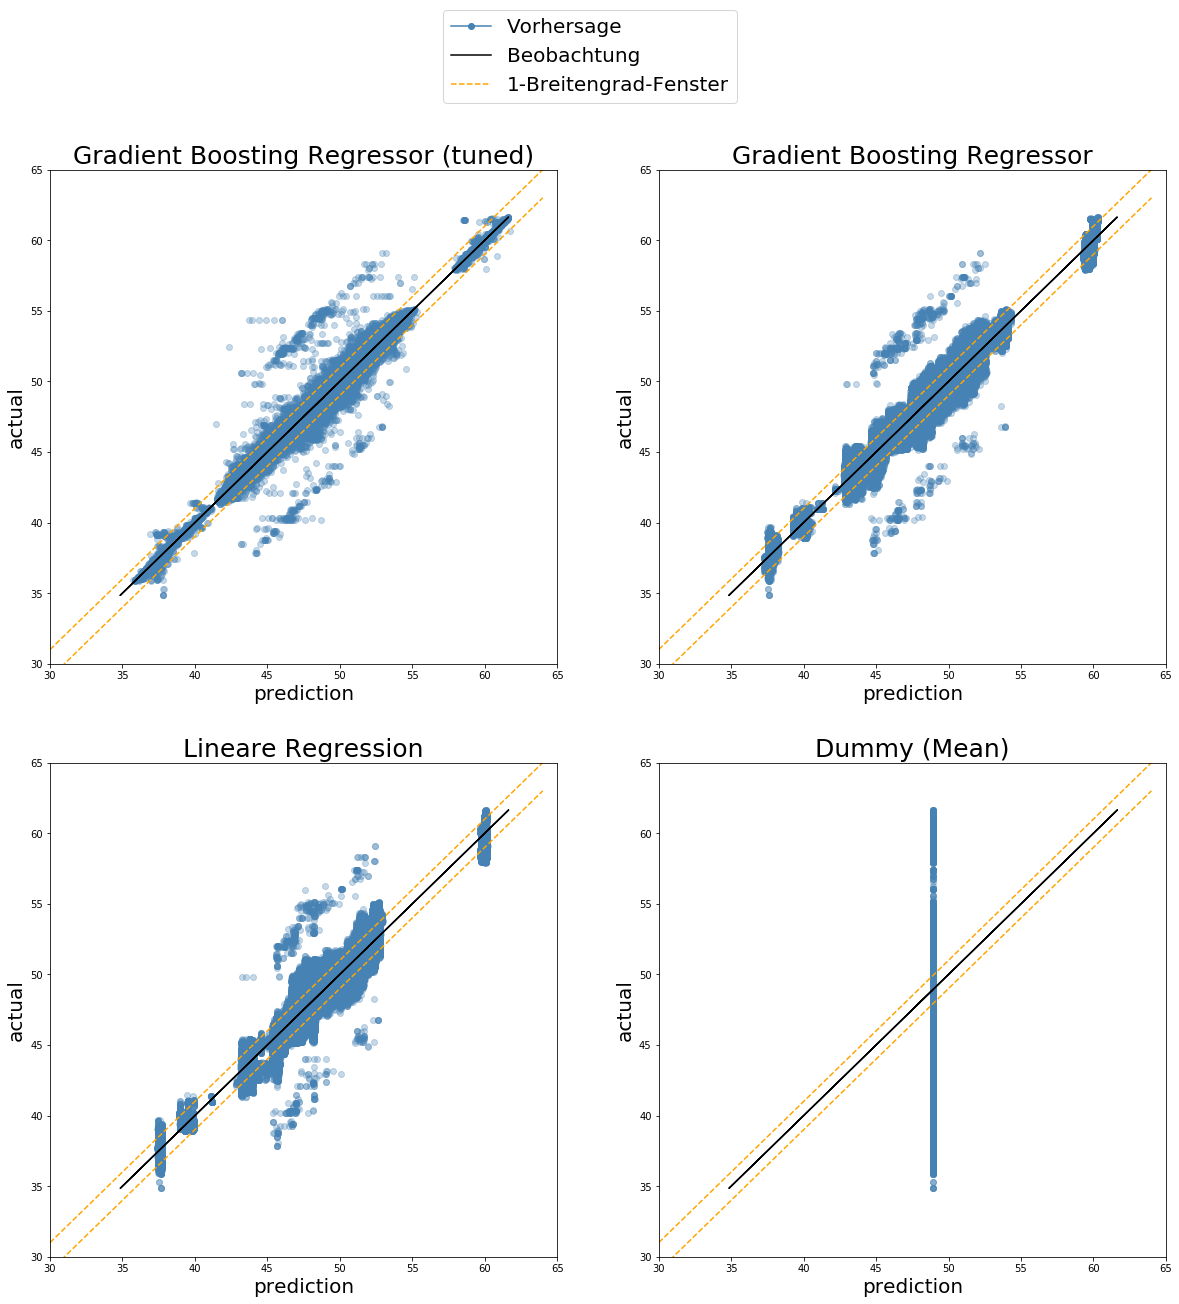

In [87]:
f = plt.figure(figsize=(20,20))


ax1 = plt.subplot(221)
ax1.scatter(gbr_tuned_pred,y_val,color='steelblue', alpha=0.3)
ax1.set_title('Gradient Boosting Regressor (tuned)')
ax1.title.set_size(25)
ax1.set_xlim([30,65])
ax1.set_ylim([30,65])
ax1.set_xlabel('prediction', fontsize = 20)
ax1.set_ylabel('actual', fontsize = 20)
x = y_val
y = y_val
plt.plot(x,y, color='black')
x2 = np.arange(30, 65)
y2 = np.arange(31, 66)
plt.plot(x2,y2, color='orange',linestyle='dashed')
x3 = np.arange(30, 65)
y3 = np.arange(29, 64)
plt.plot(x3,y3, color='orange',linestyle='dashed')

ax2 = plt.subplot(222)
ax2.scatter(gbr_pred,y_val,color='steelblue', alpha=0.3)
ax2.set_title('Gradient Boosting Regressor')
ax2.title.set_size(25)
ax2.set_xlim([30,65])
ax2.set_ylim([30,65])
ax2.set_xlabel('prediction', fontsize = 20)
ax2.set_ylabel('actual', fontsize = 20)
x = y_val
y = y_val
plt.plot(x,y, color='black')
x2 = np.arange(30, 65)
y2 = np.arange(31, 66)
plt.plot(x2,y2, color='orange',linestyle='dashed')
x3 = np.arange(30, 65)
y3 = np.arange(29, 64)
plt.plot(x3,y3, color='orange',linestyle='dashed')

ax3 = plt.subplot(223)
ax3.scatter(reg_pred,y_val,color='steelblue', alpha=0.3)
ax3.set_title('Lineare Regression')
ax3.title.set_size(25)
ax3.set_xlim([30,65])
ax3.set_ylim([30,65])
ax3.set_xlabel('prediction', fontsize = 20)
ax3.set_ylabel('actual', fontsize = 20)
x = y_val
y = y_val
plt.plot(x,y, color='black')
x2 = np.arange(30, 65)
y2 = np.arange(31, 66)
plt.plot(x2,y2, color='orange',linestyle='dashed')
x3 = np.arange(30, 65)
y3 = np.arange(29, 64)
plt.plot(x3,y3, color='orange',linestyle='dashed')

ax4 = plt.subplot(224)
ax4.scatter(dummy_pred,y_val,color='steelblue',alpha=0.4)
ax4.set_title('Dummy (Mean)')
ax4.title.set_size(25)
axes = plt.gca()
ax4.set_xlim([30,65])
ax4.set_ylim([30,65])
ax4.set_xlabel('prediction', fontsize = 20)
ax4.set_ylabel('actual', fontsize = 20)
x = y_val
y = y_val
plt.plot(x,y, color='black')
x2 = np.arange(30, 65)
y2 = np.arange(31, 66)
plt.plot(x2,y2, color='orange',linestyle='dashed')
x3 = np.arange(30, 65)
y3 = np.arange(29, 64)
plt.plot(x3,y3, color='orange',linestyle='dashed')

legend_elements = [Line2D([0], [0], marker='o', color='steelblue', label='Vorhersage'),
Line2D([0], [0], color='black', label='Beobachtung'),
Line2D([0], [0], color='orange',linestyle='dashed', label='1-Breitengrad-Fenster')]

f.legend(handles=legend_elements, loc='upper center', fontsize=20)



f.savefig("results.png")

Die Abbildung zeigt de Abweichung der Vorhersagen der verschiedenen Modellen von den beobachteten Werten als Scatterplots. 
Auch hier ist eindeutig zu erkennen, wie sich die Vorhersagen mit zunehmender Komplexität des Modells an die Beobachtungen angleichen. 
Insbesondere ist zu sehen, wie der getunte GBR in den sehr großen und sehr kleinen Breitengraden bessere Vorhersagen erzielt. 